# LSTM Network, State Space and Mixtures Models from FRED-MD

We apply and compare four methods for extracting lower-dimensional states from a large panel of economic time series: State space models, Hidden Markov Models, Gaussian mixtures, and LSTM networks.

We visualize the extracted hidden states/latent factors to recessionary and economic time periods, and compare the estimated persistence of states.


- Long Short-Term Memory networks, hidden states, state space models, Gaussian mixtures
- pytorch, hmmlearn, statsmodels, sklearn
- Chen, Pelger and Zhu (2020) and others


Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import os
import re
import time
from datetime import datetime
from finds.alfred import fred_md, Alfred

from settings import settings
imgdir = os.path.join(settings['images'], 'rnn')

# Load and pre-process time series from FRED

In [2]:
alf = Alfred(api_key=settings['fred']['api_key'])

# to indicate recession periods in the plots
usrec = alf('USREC', freq='m')
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = (usrec != usrec.shift()).cumsum()[usrec.gt(0)].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]

# Retrieve FRED-MD series
mdf, mt = fred_md(202104)  # 202104 from vintage April 2020
beg = 19600301
end = 20191231

# Apply tcode transformations
df = mdf
t = mt['transform']
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=t[col], freq='m'))
df = pd.concat(transformed, axis=1).iloc[2:]

data = df[(df.index >= beg) & (df.index <= end)].dropna(axis=1)
data = (data-data.mean(axis=0))/data.std(axis=0, ddof=0)
data.index = pd.DatetimeIndex(data.index.astype(str), freq='infer')
cols = list(data.columns)
data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
1960-03-31,-0.132999,-0.275066,2.214734,-2.859834,-0.486906,-1.495499,-0.750608,-0.403176,-0.047169,-1.035261,...,0.294872,-0.644821,-0.004883,3.307241,-1.012980,0.000267,0.381337,0.142228,0.047084,0.324320
1960-04-30,0.142224,0.203599,2.468987,0.719075,1.806369,-1.353115,0.042521,-0.112877,0.616030,-0.157768,...,0.734648,0.960530,-2.250386,-7.470795,0.000605,0.000267,-0.129945,0.355596,0.268875,2.265455
1960-05-31,-0.043479,-0.004071,-4.474670,-3.197100,-1.671091,-0.434014,0.514853,0.611498,0.479120,0.339674,...,-1.115633,0.315557,2.250736,4.568082,0.000605,-1.837784,0.124728,-0.197916,-0.101637,0.353288
1960-06-30,-0.336406,-0.481605,-0.557184,0.602805,-0.509181,-1.985166,-1.858745,-1.710214,-0.973062,-0.599717,...,0.035608,-0.483923,-1.125106,-1.253959,0.000605,0.000267,0.186875,0.210022,0.365845,-0.942185
1960-07-31,-0.147090,-0.100239,-0.121240,-0.859807,-1.250915,-0.748978,-1.074181,-0.990412,-1.245880,-1.915338,...,0.301924,0.420937,1.120443,0.828640,0.000605,0.000267,0.247603,-0.447860,-0.161941,3.021372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.235454,0.359291,-0.127541,0.363796,-0.004156,0.666996,0.043699,-0.110872,-0.314035,-0.241575,...,-0.733990,-0.542228,0.608233,0.693035,-0.097818,-2.359022,-0.013242,-0.018673,-0.079502,0.416126
2019-09-30,-0.287213,-0.251185,-0.309347,-0.264433,-0.920258,-0.749301,-1.079824,-1.253692,-0.986939,-1.452734,...,-0.086881,-0.321675,-0.305385,-0.346517,-0.194525,0.933010,0.128530,-0.164771,-0.089344,0.486888
2019-10-31,-0.354645,-0.307971,-0.155916,-0.580601,0.016521,-0.829671,-0.651355,-0.601232,-0.253689,-1.416669,...,0.928035,0.469378,0.099982,-0.038245,0.291747,0.631240,0.467873,0.080453,0.032515,-1.393876
2019-11-30,0.299609,0.489491,-0.340311,0.274246,-0.118212,0.965124,1.632276,1.999346,2.068184,2.689480,...,-0.285916,-0.506286,-0.303140,0.038317,0.289792,0.356904,-0.334767,-0.096463,-0.059249,0.416444


# Define LSTM pytorch model

In [26]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers)
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=n_features)

    def forward(self, x, hidden_state=None):
        """
        x: shape (seq_len, batch, input_siz)
        h: of shape (num_layers * num_directions, batch, hidden_size)
        c: of shape (num_layers * num_directions, batch, hidden_size)
        output: shape (seq_len, batch, num_directions * hidden_size)
        """
        output, (h, c) = self.lstm(x, hidden_state)
        return self.linear(output), (h.detach(), c.detach())
    
# create input data for LSTM, with sequence length 12 (months)
seq_len = 12
train_exs = [data.iloc[i-(seq_len+1):i].values
             for i in range(seq_len+1, len(data))]
n_features = data.shape[1]

# Initialize LSTM with hidden_size=4, on GPU device
hidden_size = 4
model = LSTM(n_features=n_features, hidden_size=hidden_size).to(device)
print(model)

# Set optimizer and learning rate scheduler, with step_size=30
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
loss_function = nn.MSELoss()

LSTM(
  (lstm): LSTM(124, 4)
  (linear): Linear(in_features=4, out_features=124, bias=True)
)


# Run training loop

with num_epochs=300 and batch_size=4 

In [27]:
batch_size = 8
num_epochs = 1000
for epoch in range(num_epochs):
    
    # shuffle indxs into batches
    idxs = np.arange(len(train_exs))
    random.shuffle(idxs)
    batches = [idxs[i:(i+batch_size)] for i in range(0, len(idxs), batch_size)]

    # train each batch
    total_loss = 0.0
    model.train()
    for batch in batches:
        # train_ex input has shape (seq_len, batch_size=16, n_features)
        train_ex = torch.tensor([[train_exs[idx][seq] for idx in batch]
                                 for seq in range(seq_len+1)]).float().to(device)
        model.zero_grad()
        y_pred, hidden_state = model.forward(train_ex[:-1])
        loss = loss_function(y_pred[-1], train_ex[-1])
        total_loss += float(loss)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch % 200) == 0:
        print(epoch, optimizer.param_groups[0]['lr'], total_loss/len(batches))


0 0.001 1.0854088001036912
200 0.0001 0.7187486160337255
400 1e-05 0.7125924946217055
600 1.0000000000000002e-06 0.7128379733374949
800 1.0000000000000002e-07 0.7217696064643646


## Collect predictions and hidden states, and compute mse

In [28]:
with torch.no_grad():    # reduces memory consumption for eval
    hidden_state = []
    prediction_error = []
    mse = nn.MSELoss()
    for i in range(seq_len+1, len(data)):
        # single test example of shape (seq_len=12, batch_size=1, n_features)
        test_ex = torch.tensor(data[i-(seq_len+1):i].values)\
                       .float().unsqueeze(dim=1).to(device)
        y_pred, (h, c) = model.forward(test_ex[:-1], None)
        prediction_error.append(float(mse(y_pred[-1], test_ex[-1])))
        hidden_state.append(h[0][0].cpu().numpy())
hidden_factors = DataFrame(hidden_state, index=data.index[(1+seq_len):len(data)])
print(np.mean(prediction_error))#

0.715434508332124


# Plot LSTM hidden states process

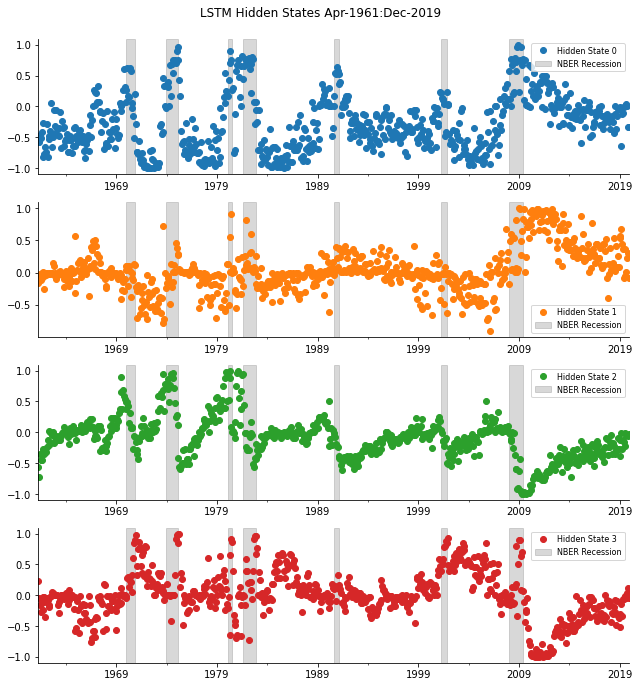

In [29]:
fig = plt.figure(figsize=(9, 10), num=1, clear=True)
for col in hidden_factors.columns:
    ax = fig.add_subplot(4, 1, col+1)
    (np.sign(hidden_factors[col].corr(usrec))*
     hidden_factors[col]).plot(ax=ax, style='o', color=f"C{col}")
    for a,b in vspans:
        ax.axvspan(a, b, alpha=0.3, color='grey')
    ax.legend([f"Hidden State {col}", 'NBER Recession'], fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"LSTM Hidden States {hidden_factors.index[0]:%b-%Y}:"
             f"{hidden_factors.index[-1]:%b-%Y}", fontsize=12)
plt.savefig(os.path.join(imgdir, 'lstm.jpg'))
plt.show()

# Dynamic Factor Models

- can be cast into state space form and estimated via Kalman Filter

https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_dfm_coincident.html

## Fit (linear) dynamic factor model with DynamicFactorMQ
https://www.statsmodels.org/devel/generate/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html

Allows for

- mixed frequency data (for nowcasting)
- EM algorithm by default accomodates larger data sets:  Kalman filter and optimizing of likelihood with quasi-Newton methods slow

In [30]:
import statsmodels.api as sm
mod = sm.tsa.DynamicFactorMQ(endog=data,
                             factors=1,                # num factor blocks
                             factor_multiplicities=4,  # num factors in block
                             factor_orders=12,         # order of factor VAR
                             idiosyncratic_ar1=False)  # False=white noise
fitted = mod.fit_em(disp=False, maxiter=1000, full_output=True)
dynamic_factors = DataFrame(fitted.factors.filtered.iloc[seq_len+1:])
dynamic_factors.columns = list(np.arange(len(dynamic_factors.columns)))

# compute mse of fitted observations
mse = nn.MSELoss()
print(float(mse(torch.tensor(fitted.fittedvalues.iloc[seq_len+1:].values),
                torch.tensor(data.iloc[seq_len+1:].values))))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1934: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2', '0.3', '0.4'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


0.7938809367226097


## Plot estimated dynamic factors

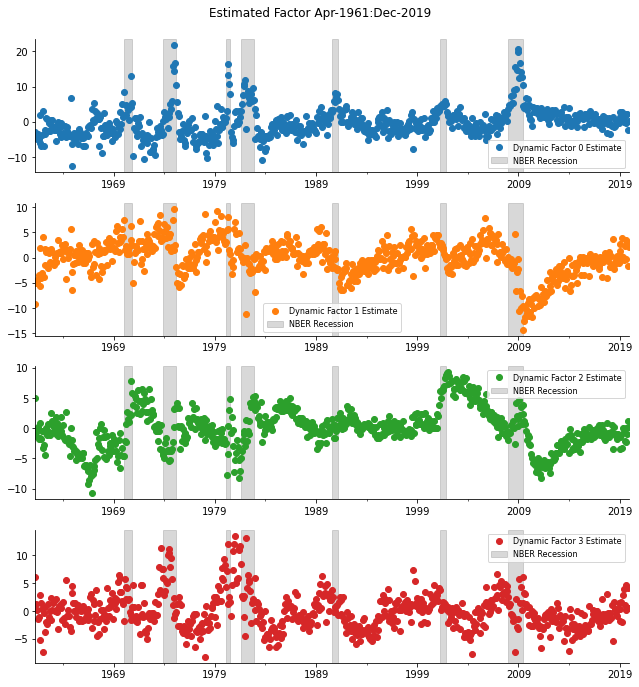

In [31]:
fig = plt.figure(figsize=(9, 10), num=2, clear=True)
for col in dynamic_factors.columns:
    ax = fig.add_subplot(4, 1, col+1)
    (np.sign(dynamic_factors[col].corr(usrec))*
     dynamic_factors[col]).plot(ax=ax, style='o', color=f"C{col}")
    for a,b in vspans:
        ax.axvspan(a, b, alpha=0.3, color='grey')
    ax.legend([f"Dynamic Factor {col} Estimate", 'NBER Recession'], fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Estimated Factor {dynamic_factors.index[0]:%b-%Y}:"
             f"{dynamic_factors.index[-1]:%b-%Y}", fontsize=12)
plt.savefig(os.path.join(imgdir, 'dynamic.jpg'))
plt.show()

## Correlation of LSTM hidden state process with (linear) dynamic factors

LSTM Hidden States explained by four dynamic (linear) factors with Rsquared averaging 70% 

In [32]:
for col, y in hidden_factors.iteritems():
    res = sm.OLS(y, sm.add_constant(dynamic_factors)).fit()
    print()
    print('Hidden Factor', col, '  rsquared =', np.round(res.rsquared, 4))
    print(res.summary().tables[1])


Hidden Factor 0   rsquared = 0.7197
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2559      0.009     27.900      0.000       0.238       0.274
0              0.0690      0.002     31.772      0.000       0.065       0.073
1              0.0312      0.003     11.933      0.000       0.026       0.036
2              0.0424      0.003     15.236      0.000       0.037       0.048
3              0.0510      0.003     18.087      0.000       0.045       0.057

Hidden Factor 1   rsquared = 0.612
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0410      0.008      5.155      0.000       0.025       0.057
0             -0.0302      0.002    -16.078      0.000      -0.034      -0.027
1             -0.0519      0.002    -22.943      0.000    

# Hidden Markov Model from FRED-MD
- Gaussian HMM
- Fit with 3 states
- Display estimated transition and stationary probabilities

In [4]:
from hmmlearn import hmm
n_components = 3
markov = hmm.GaussianHMM(n_components=n_components,
                         covariance_type="full",
                         verbose=False,
                         tol=1e-6,
                         n_iter=100,
                         algorithm='viterbi')\
            .fit(data.values, [len(data)])
print('Dimension of observations:', markov.n_features)
print(markov.monitor_)
pred = DataFrame(markov.predict(data), columns=['state'], index=data.index)
matrix = DataFrame(markov.transmat_).rename_axis(columns='Transition Matrix:')
matrix['Stationary'] = markov.get_stationary_distribution()
matrix

Dimension of observations: 124
ConvergenceMonitor(
    history=[-58532.430085602726, -43255.31811773657, -32331.014985721155, -31902.046528738123, -31901.988466913623, -31901.988466922743],
    iter=6,
    n_iter=100,
    tol=1e-06,
    verbose=False,
)


Transition Matrix:,0,1,2,Stationary
0,0.877451,0.049020,0.073529,0.292067
1,0.082707,0.661654,0.255639,0.181521
2,0.039474,0.089474,0.871053,0.526412


## Helper to plot predicted states

In [7]:
def plot_states(modelname, labels, beg, end):
    n_components = len(np.unique(labels))
    markers = ["o", "s", "d", "X", "P", "8", "H", "*", "x", "+"][:n_components] 
    series_ids = ['IPMANSICS', 'S&P 500', 'AAAFFM', 'GS1']
    df = mdf[series_ids].copy()
    df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
    df = df[(df.index >= beg) & (df.index <= end)]
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9,10), num=1, clear=True)
    axes[0].set_title(f"{modelname} Predicted States", {'fontsize':9})
    for s, ax in zip(series_ids, axes.ravel()):
        for i, marker in zip(range(n_components), markers):
            df.loc[labels==i, s].plot(ax=ax, style=marker, markersize=2,
                                      color=f"C{i}", rot=0)
            ax.set_xlabel(f"{s}: {alf.header(s)}", {'fontsize':8})
        for a,b in vspans:
            if (b > min(df.index)) & (a < max(df.index)):
                ax.axvspan(max(a, min(df.index)), min(b, max(df.index)),
                           alpha=0.3, color='grey')
        ax.legend([f"state {i}" for i in range(n_components)], fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, f"{modelname.lower()}.jpg"))


## Plot selected series by predicted state
- one of the states (state 2, green color) indicates periods of economic slowdown
- the other two states indicate two sets of periods of economy recovery: 
 - one for post-1992 and post-2010 suggesting these two periods enjoyed similar recoveries (we should examine differences in the regime means_ and covars_ of the observed features)


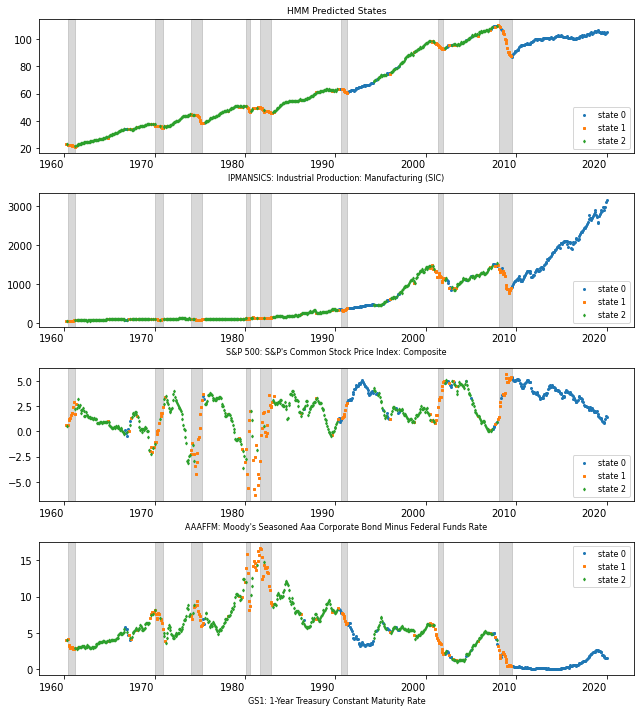

In [8]:
plot_states('HMM', pred.values.flatten(), min(pred.index), max(pred.index))
plt.show()

# Gaussian Mixtures Model from FRED-MD
- Fit with 3 states
- Plot predicted states, with representative economic time series


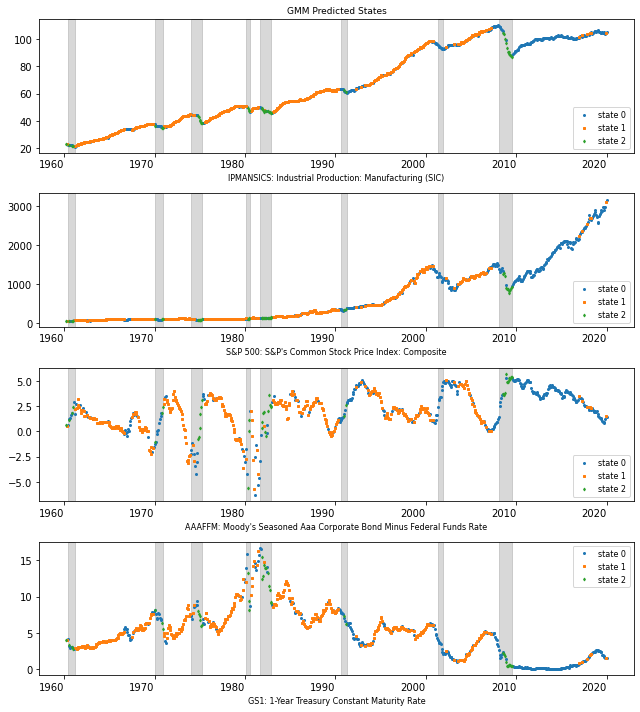

In [9]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(data)
labels = gmm.predict(data)
plot_states('GMM', labels, min(data.index), max(data.index))
plt.show()


## Compare persistance of states

In [24]:
print("Persistance of Hidden Markov states:", np.mean(pred[:-1].values == pred[1:].values))
print("Persistance of Gaussian Mixtures states:", np.mean(labels[:-1] == labels[1:]))

Persistance of Hidden Markov states: 0.8340306834030683
Persistance of Gaussian Mixtures states: 0.7475592747559274
